# Algoritmo de Clasificasión, usando sklearn y árboles

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [2]:
datos_consultas = pd.read_csv('consultasHraecs.csv')
from sklearn.model_selection import cross_val_score
datos_consultas.shape

(8283, 12)

In [3]:
datos_consultas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8283 entries, 0 to 8282
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID CONSULTA       8283 non-null   int64 
 1   FECHA             8283 non-null   object
 2   HORA              8283 non-null   object
 3   ESPECIALIDAD      8283 non-null   object
 4   EXPEDIENTE        8283 non-null   int64 
 5   SEXO              8283 non-null   object
 6   EDAD              8283 non-null   int64 
 7   MUNICIPIO         8283 non-null   object
 8   ESTADO            8283 non-null   object
 9   DERECHOHABIENCIA  8283 non-null   object
 10  ID_DX             8283 non-null   object
 11  DIAGNOSTICO       8283 non-null   object
dtypes: int64(3), object(9)
memory usage: 776.7+ KB


In [6]:
datos_consultas.head()

,ID CONSULTA,FECHA,HORA,ESPECIALIDAD,EXPEDIENTE,SEXO,EDAD,MUNICIPIO,ESTADO,DERECHOHABIENCIA,ID_DX,DIAGNOSTICO
0,28943300245,02/01/20,0:30:28,NEUROCIRUGIA,34820,F,46,ARRIAGA,CHIAPAS,SEGURO POPULAR,D434,Tumor de comportamiento incierto o desconocido...
1,28943400245,02/01/20,0:10:58,NEUROCIRUGIA,35731,M,63,UNION JUAREZ,CHIAPAS,SEGURO POPULAR,I601,Hemorragia subaracnoidea de arteria cerebral m...
2,28943500245,02/01/20,0:27:00,NEUROCIRUGIA,36579,F,27,TAPACHULA,CHIAPAS,SEGURO POPULAR,M544,Lumbago con ciática
3,28943900245,02/01/20,0:11:08,NEUMOLOGIA,37026,F,30,TAPACHULA,CHIAPAS,SEGURO POPULAR,J998,Trastornos respiratorios en otras enfermedades...
4,28944100245,02/01/20,0:52:37,NEUMOLOGIA,36009,F,45,FRONTERA COMALAPA,CHIAPAS,SEGURO POPULAR,J998,Trastornos respiratorios en otras enfermedades...


In [7]:
datos_consultas['SEXO'].value_counts()

F    5595
M    2688
Name: SEXO, dtype: int64

# MAPEO DE DATOS

In [8]:
# Mood Mapping 
datos_consultas['mapSexo']=datos_consultas['SEXO'].map({'F':1,'M':0}).astype(int)

In [9]:
datos_consultas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8283 entries, 0 to 8282
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID CONSULTA       8283 non-null   int64 
 1   FECHA             8283 non-null   object
 2   HORA              8283 non-null   object
 3   ESPECIALIDAD      8283 non-null   object
 4   EXPEDIENTE        8283 non-null   int64 
 5   SEXO              8283 non-null   object
 6   EDAD              8283 non-null   int64 
 7   MUNICIPIO         8283 non-null   object
 8   ESTADO            8283 non-null   object
 9   DERECHOHABIENCIA  8283 non-null   object
 10  ID_DX             8283 non-null   object
 11  DIAGNOSTICO       8283 non-null   object
 12  mapSexo           8283 non-null   int64 
dtypes: int64(4), object(9)
memory usage: 841.4+ KB


In [34]:
# Mood Mapping 
#datos_consultas['ESPECIALIDAD'].value_counts()
#datos_consultas['DERECHOHABIENCIA'].value_counts()
datos_consultas['ESTADO'].value_counts()


CHIAPAS            8124
SE DESCONOCE        137
OAXACA               21
BAJA CALIFORNIA       1
Name: ESTADO, dtype: int64

# CLASIFICACIÓN - MAPEO DE DATOS

In [10]:
#MAPEO CAMPO SEXO
datos_consultas['mapSexo']=datos_consultas['SEXO'].map({'M':0,'F':1}).astype(int)
#MAPEO CAMPO EDAD
datos_consultas.loc[datos_consultas['EDAD'] <= 17, 'mapEdad']= 0
datos_consultas.loc[(datos_consultas['EDAD'] >= 18)& (datos_consultas['EDAD'] <= 25), 'mapEdad']= 1
datos_consultas.loc[(datos_consultas['EDAD'] >= 26)& (datos_consultas['EDAD'] <= 50), 'mapEdad']= 2
datos_consultas.loc[(datos_consultas['EDAD'] >= 51)& (datos_consultas['EDAD'] <= 75), 'mapEdad']= 3
datos_consultas.loc[(datos_consultas['EDAD'] >= 76), 'mapEdad']= 4
#CAMPO DERECHOHABIENCIA
datos_consultas['mapHabiencia']=datos_consultas['DERECHOHABIENCIA'].map({'NINGUNA':0,
                                                                         'SE IGNORA':0,'IMSS':1, 
                                                                         'ISSSTE':2,'ISSTECH':3,
                                                                         'OPORTUNIDADES':4,'SEDENA':5,
                                                                         'SEGURO POPULAR':6}).astype(int)
#CAMPO ESTADO
datos_consultas['mapEdo']=datos_consultas['ESTADO'].map({'CHIAPAS':1,'SE DESCONOCE':0,'OAXACA':0,'BAJA CALIFORNIA':0}).astype(int)
#CAMPO FECHA
#Para formatear el campo fecha es necesario que se convierta a tipo date el campo del archivo fuente
from datetime import datetime
datos_consultas['FECHA']=datos_consultas[['FECHA']].apply(pd.to_datetime, format='%d/%m/%y')
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/01/01')& (datos_consultas['FECHA'] <= '2020/01/31'), 'mapFecha']= 1
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/02/01')& (datos_consultas['FECHA'] <= '2020/02/29'), 'mapFecha']= 2
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/03/01')& (datos_consultas['FECHA'] <= '2020/03/31'), 'mapFecha']= 3
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/04/01')& (datos_consultas['FECHA'] <= '2020/04/30'), 'mapFecha']= 4
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/05/01')& (datos_consultas['FECHA'] <= '2020/05/31'), 'mapFecha']= 5
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/06/01')& (datos_consultas['FECHA'] <= '2020/06/30'), 'mapFecha']= 6
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/07/01')& (datos_consultas['FECHA'] <= '2020/07/31'), 'mapFecha']= 7
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/08/01')& (datos_consultas['FECHA'] <= '2020/08/31'), 'mapFecha']= 8
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/09/01')& (datos_consultas['FECHA'] <= '2020/09/30'), 'mapFecha']= 9
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/10/01')& (datos_consultas['FECHA'] <= '2020/10/31'), 'mapFecha']= 10
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/11/01')& (datos_consultas['FECHA'] <= '2020/11/30'), 'mapFecha']= 11
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/12/01')& (datos_consultas['FECHA'] <= '2020/12/31'), 'mapFecha']= 12


In [11]:
datos_consultas['mapHabiencia']=datos_consultas['DERECHOHABIENCIA'].map({'SEGURO POPULAR':6,
                                                                         'NINGUNA':0,'SE IGNORA':0, 
                                                                         'ISSSTE':2,'IMSS':1,'ISSTECH':3,
                                                                         'OPORTUNIDADES':4,'SEDENA':5}).astype(int)
                                                                         

In [12]:
datos_consultas['mapEdo']=datos_consultas['ESTADO'].map({'CHIAPAS':1,'SE DESCONOCE':0,'OAXACA':0,'BAJA CALIFORNIA':0}).astype(int)


In [13]:
datos_consultas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8283 entries, 0 to 8282
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID CONSULTA       8283 non-null   int64         
 1   FECHA             8283 non-null   datetime64[ns]
 2   HORA              8283 non-null   object        
 3   ESPECIALIDAD      8283 non-null   object        
 4   EXPEDIENTE        8283 non-null   int64         
 5   SEXO              8283 non-null   object        
 6   EDAD              8283 non-null   int64         
 7   MUNICIPIO         8283 non-null   object        
 8   ESTADO            8283 non-null   object        
 9   DERECHOHABIENCIA  8283 non-null   object        
 10  ID_DX             8283 non-null   object        
 11  DIAGNOSTICO       8283 non-null   object        
 12  mapSexo           8283 non-null   int64         
 13  mapEdad           8283 non-null   float64       
 14  mapHabiencia      8283 n

In [14]:
from datetime import datetime
#datos_consultas['FECHA'] = datetime.strptime(datos_consultas['FECHA'], '%dd/%mm/%Y')
#datos_consultas['FECHA'] =pd.to_datetime(FECHA)
datos_consultas['FECHA']=datos_consultas[['FECHA']].apply(pd.to_datetime, format='%d/%m/%y')
#pd.to_datetime(datos_consultas[FECHA], errors ='coerce')

In [15]:
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/01/01')& (datos_consultas['FECHA'] <= '2020/01/31'), 'mapFecha']= 1
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/02/01')& (datos_consultas['FECHA'] <= '2020/02/29'), 'mapFecha']= 2
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/03/01')& (datos_consultas['FECHA'] <= '2020/03/31'), 'mapFecha']= 3
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/04/01')& (datos_consultas['FECHA'] <= '2020/04/30'), 'mapFecha']= 4
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/05/01')& (datos_consultas['FECHA'] <= '2020/05/31'), 'mapFecha']= 5
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/06/01')& (datos_consultas['FECHA'] <= '2020/06/30'), 'mapFecha']= 6
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/07/01')& (datos_consultas['FECHA'] <= '2020/07/31'), 'mapFecha']= 7
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/08/01')& (datos_consultas['FECHA'] <= '2020/08/31'), 'mapFecha']= 8
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/09/01')& (datos_consultas['FECHA'] <= '2020/09/30'), 'mapFecha']= 9
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/10/01')& (datos_consultas['FECHA'] <= '2020/10/31'), 'mapFecha']= 10
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/11/01')& (datos_consultas['FECHA'] <= '2020/11/30'), 'mapFecha']= 11
datos_consultas.loc[(datos_consultas['FECHA'] >= '2020/12/01')& (datos_consultas['FECHA'] <= '2020/12/31'), 'mapFecha']= 12

In [82]:
datos_consultas['ESPECIALIDAD'].value_counts()


ENDOCRINOLOGÍA                      1213
CARDIOLOGIA                         1123
ONCOLOGIA                            665
MEDICINA INTERNA                     504
CARDIOLOGIA INTERVENSIONITA          462
GINECOLOGIA ONCOLOGICA               451
GASTROENTEROLOGIA                    422
PROCTOLOGIA                          282
UROLOGIA                             272
NUTRIOLOGIA                          268
ONCOLOGIA MEDICA                     263
TRAUMATOLOGIA Y ORTOPEDIA            245
CIRUGIA                              238
NEUROLOGIA                           228
PATOLOGIA                            205
MEDICINA DE REHABILITACION           192
GENETICA MEDICA                      183
DERMATOLOGIA                         178
NEUROCIRUGIA                         161
ANESTESIOLOGIA                       134
GINECOLOGIA                          121
CIRUGIA CARDIOVASCULAR                91
NEUMOLOGIA                            82
AUDIOLOGIA                            62
OFTALMOLOGIA    

In [16]:
datos_consultas['mapEspecialidad']=datos_consultas['ESPECIALIDAD'].map({'ALERGOLOGIA':1,
                                                                        'ANESTESIOLOGIA':2,
                                                                       'ANGIOLOGIA':3,
                                                                       'AUDIOLOGIA':4,
                                                                       'CARDIOLOGIA':5,
                                                                       'CARDIOLOGIA INTERVENSIONITA':6,
                                                                       'CIRUGIA':7,
                                                                       'CIRUGIA CARDIOVASCULAR':8,
                                                                       'CIRUGIA MAXILOFACIAL':9,
                                                                       'CIRUGIA VASCULAR':10,
                                                                       'DERMATOLOGIA':11,
                                                                       'ENDOCRINOLOGÍA':12,
                                                                       'GASTROENTEROLOGIA':13,
                                                                       'GENETICA MEDICA':14,
                                                                       'GINECOLOGIA':15,
                                                                       'GINECOLOGIA ONCOLOGICA':16,
                                                                       'INFECTOLOGIA':17,
                                                                       'MEDICINA DE REHABILITACION':18,
                                                                       'MEDICINA INTERNA':19,
                                                                       'NEFROLOGIA':20,
                                                                       'NEUMOLOGIA':21,
                                                                       'NEUROCIRUGIA':22,
                                                                       'NEUROLOGIA':23,
                                                                       'NUTRIOLOGIA':24,
                                                                       'OFTALMOLOGIA':25,
                                                                       'ONCOLOGIA':26,
                                                                       'ONCOLOGIA MEDICA':27,
                                                                       'OTORRINOLARINGOLOGIA':28,
                                                                       'PATOLOGIA':29,
                                                                       'PROCTOLOGIA':30,
                                                                       'PSICOLOGIA':31,
                                                                       'TERAPIA ENDOVASCULAR NEUROLOGICA':32,
                                                                       'TRAUMATOLOGIA Y ORTOPEDIA':33,
                                                                       'UROLOGIA':34,
                                                                       'NA':35}
                                                                      ).astype(int)

CREANDO EL FRAME DE LOS DATOS QUE HAN SIDO MAPEADOS, PARA INCIAR EL PROCESO DE PRESENTACIÓN DE LOS DATOS CLASIFICADOS EN UN ÁRBOL DE DESICIÓN 

In [17]:
drop_elements = ['ID CONSULTA','FECHA','HORA','ESPECIALIDAD','EXPEDIENTE','SEXO','EDAD','MUNICIPIO','ESTADO','DERECHOHABIENCIA','ID_DX','DIAGNOSTICO','mapEspecialidad']
datosMapeados = datos_consultas.drop(drop_elements, axis = 1)

In [18]:
datosMapeados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8283 entries, 0 to 8282
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mapSexo       8283 non-null   int64  
 1   mapEdad       8283 non-null   float64
 2   mapHabiencia  8283 non-null   int64  
 3   mapEdo        8283 non-null   int64  
 4   mapFecha      8283 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 323.7 KB


In [96]:
datosMapeados.head()

,mapSexo,mapEdad,mapHabiencia,mapEdo,mapFecha
0,1,2.0,6,1,1.0
1,0,3.0,6,1,1.0
2,1,2.0,6,1,1.0
3,1,2.0,6,1,1.0
4,1,2.0,6,1,1.0


In [21]:
datosMapeados.to_csv("datos_clasificados.csv")

In [109]:
datosMapeados.shape

(8283, 5)

ANALIZANDO LOS DATOS DEL FRAME "DATOSMAPEADOS"

In [107]:
datosMapeados[['mapEdad', 'mapSexo']].groupby(['mapEdad'], as_index=False).agg(['mean', 'count', 'sum'])

mapSexo            
             mean count   sum
mapEdad                      
0.0      0.772727    22    17
1.0      0.590022   461   272
2.0      0.735322  3185  2342
3.0      0.659818  3845  2537
4.0      0.554545   770   427

<AxesSubplot:ylabel='mapSexo'>

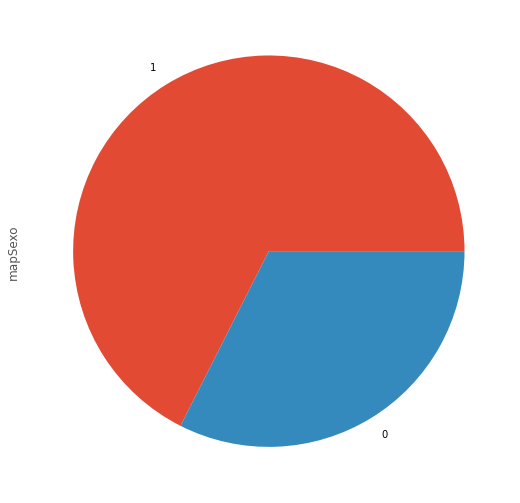

In [111]:
datosMapeados['mapSexo'].value_counts().plot(kind='pie')

In [105]:
datosMapeados[['mapHabiencia', 'mapSexo']].groupby(['mapHabiencia'], as_index=False).agg(['mean', 'count', 'sum'])

mapSexo            
                  mean count   sum
mapHabiencia                      
0             0.571197  1236   706
1             0.585366    82    48
2             0.656716   134    88
3             0.814815    27    22
4             0.666667     3     2
5             1.000000     2     2
6             0.695249  6799  4727

<AxesSubplot:ylabel='mapHabiencia'>

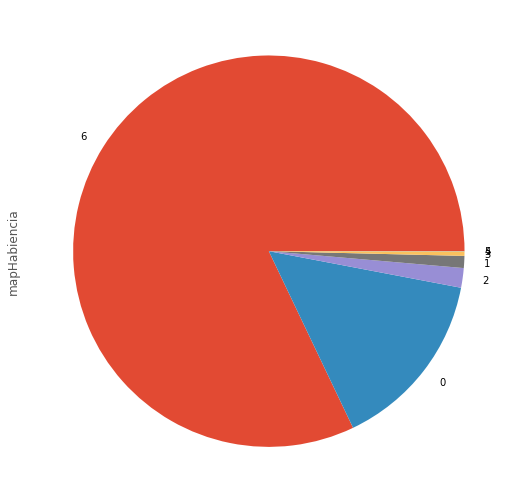

In [113]:
datosMapeados['mapHabiencia'].value_counts().plot(kind='pie')

In [123]:
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(datosMapeados))
depth_range = range(1, max_attributes + 1)
 
# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={0:2.0})
    for train_fold, valid_fold in cv.split(datosMapeados):
        f_train = datosMapeados.loc[train_fold] 
        f_valid = datosMapeados.loc[valid_fold] 
 
        model = tree_model.fit(X = f_train.drop(['mapSexo'], axis=1), 
                               y = f_train["mapSexo"]) 
        valid_acc = model.score(X = f_valid.drop(['mapSexo'], axis=1), 
                                y = f_valid["mapSexo"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)
 
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.626345
         2          0.623569
         3          0.639994
         4          0.634680
         5          0.597875


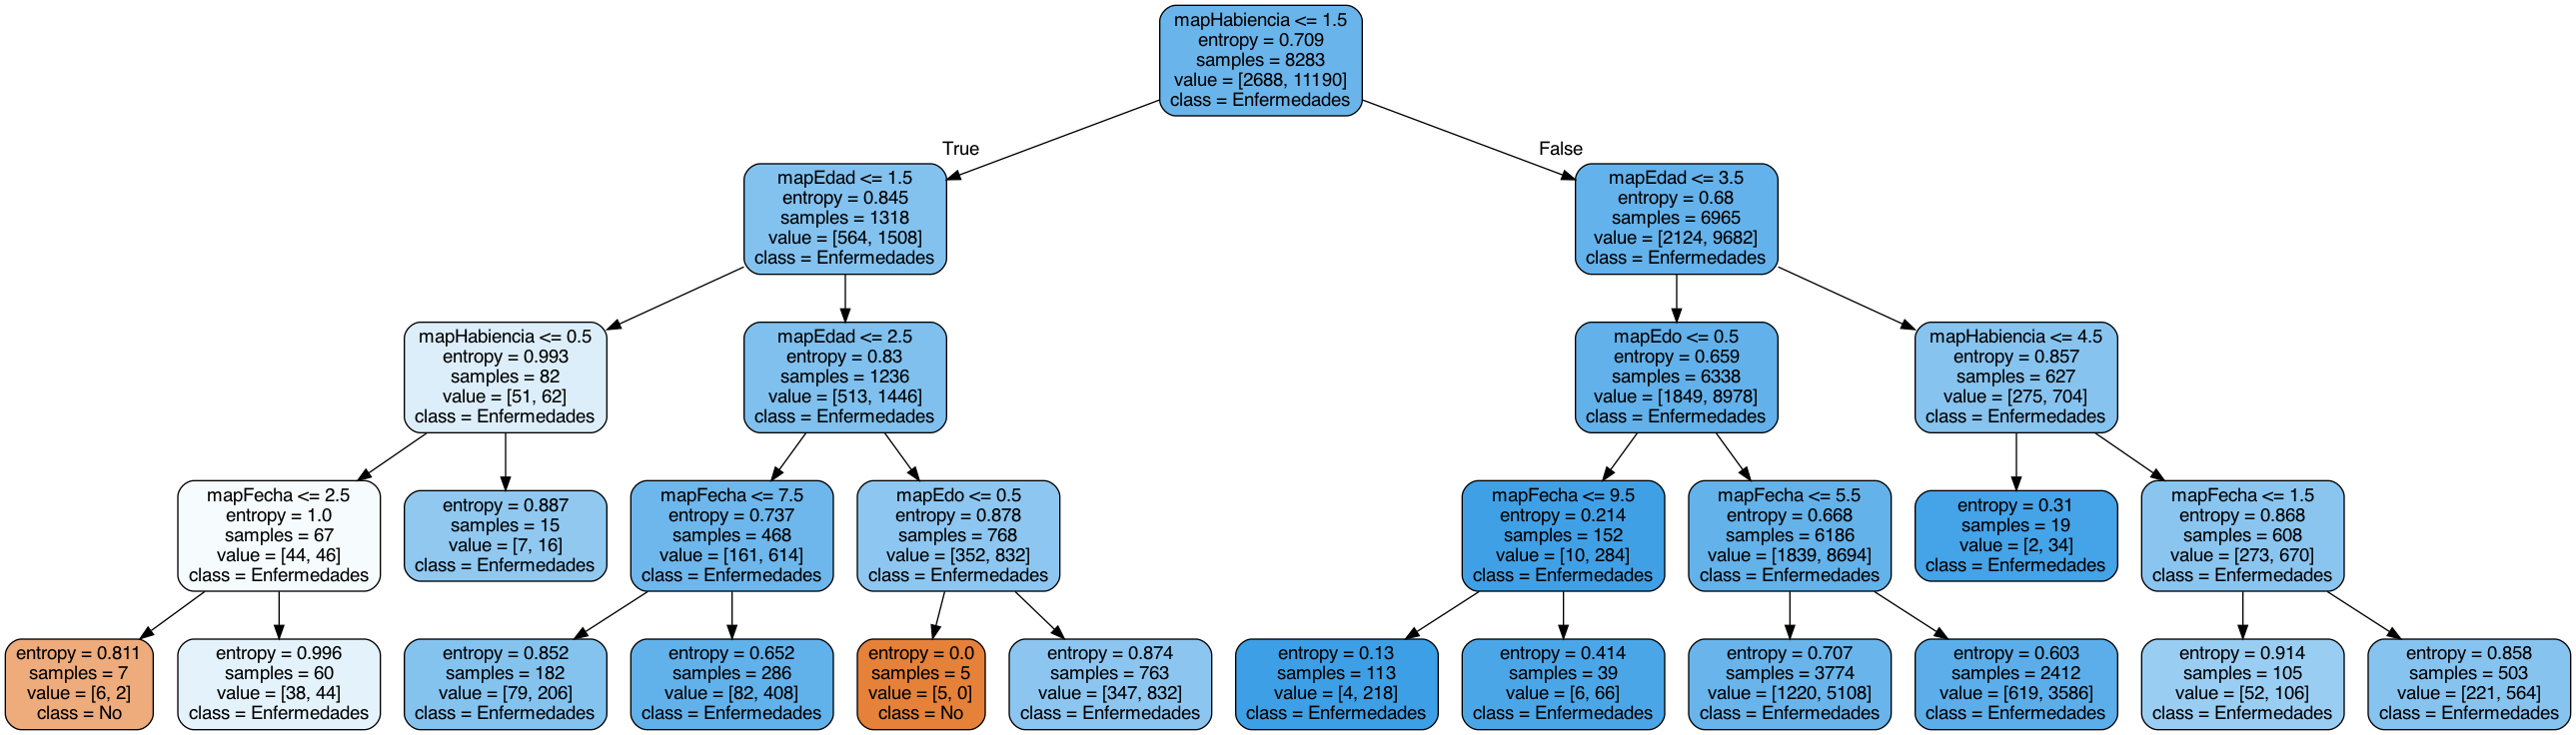

In [124]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no 
y_train = datosMapeados['mapSexo']
x_train = datosMapeados.drop(['mapSexo'], axis=1).values 
 
# Crear Arbol de decision con profundidad = 4
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            class_weight={1:2.0})
decision_tree.fit(x_train, y_train)
 
#exportar el modelo a archivo .dot
with open("arbol.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              feature_names = list(datosMapeados.drop(['mapSexo'], axis=1)),
                              class_names = ['No', 'Enfermedades'],
                              rounded = True,
                              filled= True )
check_call(['dot','-Tpng','arbol.dot','-o','arbol.png'])
PImage("arbol.png")


In [125]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(acc_decision_tree)

67.67


PREDICCION DE QUE UNA MUJER DE MAS DE 76 AÑOS, QUE TENGA DERECHO HABIENCIA SEGURO POPULAR LLEGUE A CONSULTA  

In [126]:
x_test = pd.DataFrame(columns=('mapSexo','mapEdad', 'mapHabiencia', 'mapEdo','mapFecha',))
x_test.loc[0] = (1,4,6,1,1)
y_pred = decision_tree.predict(x_test.drop(['mapSexo'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['mapSexo'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [1]
Probabilidad de Acierto: 67.09%


SE VE UNA PROBABILIDAD DE QUE LLEGUE DE UN 67%

PREDICCION DE QUE UN HOMBRE MENOR DE EDAD, QUE NO TENGA DERECHO HABIENCIA LLEGUE A CONSULTA  

In [127]:
x_test = pd.DataFrame(columns=('mapSexo','mapEdad', 'mapHabiencia', 'mapEdo','mapFecha'))
x_test.loc[0] = (0,1,0,1,1)
y_pred = decision_tree.predict(x_test.drop(['mapSexo'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['mapSexo'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: 75.0%


SE VE UNA PROBABILIDAD DE QUE NO LLEGUE DE UN 75%